# <span style="color:#1111AA">Fabry-Perot cavity: Resonance</span>

# Table of Contents

# 1. Overview

## 1.1. Introduction

Optical cavities are based on the the original idea for a spectroscopy standard published by Fabry and Perot in 1899. Cavities are fundamental building blocks of current gravitational wave detectors and important instruments in laser optics in general. In this session we model a Fabry-Perot cavity, which consists of two parallell mirrors, and we look at how its optical properties depends on the macrosopical and microscopical cavity lengths.

## 1.2. Prerequisites and reading material

We recommend that you have done the following notebooks before starting this one:
* [01_01_01_Ipython_notebook](../../01_Introduction/01_01_Ipython_notebook)
* [01_02_02_Pykat](../../01_Introduction/01_02_Pykat/01_02_01_Pykat.ipynb)
* [01_02_02_Finesse](../../01_Introduction/01_03_Finesse/01_03_01_Finesse.ipynb)

or have corresponding basic experience of Ipython notebooks, PyKat, and Finesse. The links above only works if you started ipython notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3).

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf).

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/)

## 1.3. After this session you will be able to...

* create your own FINESSE model of a cavity.
* calibrate your cavity model to be on resonance

# 2. Optical Cavities (Fabry-Perot Interferometers)

## 2.1. Importing packages

We start by loading the needed packages:

In [3]:
import numpy as np                         # Importing numpy
import matplotlib                          # Importing matplotlib, so we can plot figures
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool.
pykat.init_pykat_plotting(dpi=90)          

## 2.2. The Optical Layout

The setup we want to model looks like this:

In [2]:
HTML('<img src="fabry-perot.svg" width=600 height=600/>')

## 2.3. Length and Mirror Positions

The resonance condition of the cavity depends on the optical path lengths modulo the laser wavelength, i.e. for the light of a Nd:YAG laser ($\lambda = 1064$ nm), length differences of less than 1 μm are of interest. Some orders of magnitude:
  * LIGO peak senitivity in meters: $\sim 10^{-20}$ m
  * LIGO cavity mirror postion control accuracy: $< 10^{-12}$ m
  * LIGO arm cavity length: $\sim 10^3$ m
  * relative numerical accuracy of floating point numbers: $10^{-15}$


Therefore, it is convenient to split distances D between optical components into two parameters: one is the macroscopic ‘length’ L defined now as that multiple of the default wavelength $\lambda_0$ yielding the smallest difference to D. The second parameter is the microscopic tuning that is defined as the remaining difference between L and D. This tuning is usually given as a phase "phi" (in radians) with 2π referring to one wavelength. In FINESSE tunings are entered and printed in degrees, so that a tuning of phi = 360 degrees refers to a change in the position of the component by one wavelength ($\lambda_0$). In FINESSE macroscopical lengths are assigned to space components (keyword `s`) and microscopiacal tunings are assigned to optical components such as mirrors, beam splitters, lenes etc. You can read more about how lengths and tuning are defined in FINESSE in section 2.5 in Freise et al. [1]. 

## 2.4. The FINESSE model

Lets build an optical model in FINESSE matching the setup in the figure above.

In [4]:
basekat=finesse.kat() # initialising Finesse
basekat.verbose = False
basecode = """
l laser 1 0 n0   # Laser (Power = 1 W, wavelength offset = 0)
s s1 1 n0 nc1    # Space (Length = 1 m)

## The cavity ##
m m1 0.7 0.3 0 nc1 nc2  # Mirror  (R = 0.8, T = 0.2, phi = 0)
s sL 4000 nc2 nc3       # Space (Length = 4 km)
m m2 0.8 0.2 0 nc3 nc4  # Mirror  (R = 0.9, T = 0.1, phi = 0)
"""
basekat.parseKatCode(basecode) # Parsing the FINESSE-code

We call this kat-object *basekat* since it describes the core optics of the system we will investigate throughout this notebook.

## 2.5. Cavity Resonance

To start with we look at the light power reflected by, transmitted through, and circulating inside the cavity. On the x-axis we will change the microscopic mirror position (tuning or phi), which should be the key parameter to see a change in the response of the cavity. Lets see if this is true by adding photo diodes that measures what we want while varying the tuning of the mirror `m1`.

In [20]:
kat1 = deepcopy(basekat)
code = """
## Detectors ##
# Photo diodes measureing DC-power
pd refl nc1   
pd circ nc2
pd tran nc4

## Simulation instructions ##
xaxis m1 phi lin -450 90 400   # Varying tuning of input mirror m1.
yaxis abs                      # Plotting the amplitude of the detector measurements. 
"""
kat1.parseKatCode(code) # Parsing the FINESSE-code
out1 = kat1.run()       # Running the FINESSE-simulation, storing output in out1.

Plotting results:

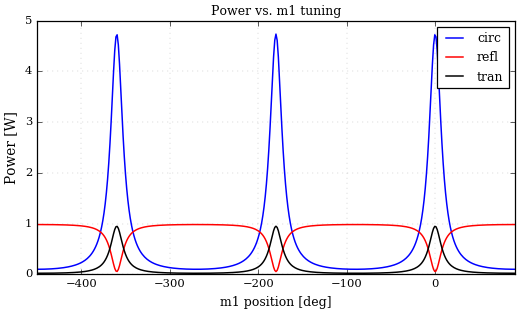

In [21]:
fig2 = out1.plot(xlabel='m1 position [deg]',
                 ylabel='Power [W]',
                 title='Power vs. m1 tuning')

Clearly the response of the cavity depends heavily on the tuning, as expected. At resonance (e.g. at m1 position = 0), the reflected power is minimal and the transmitted and circulating power are maximal. At anti-resonance (e.g. m1 position = -90) almost all power is reflected. The resonances occur every 180 deg which is equivalent to position changes of $\lambda_0/2$, or changes in round-trip length by $\lambda_0$, as expected.

# 3. Your Tasks

We want to explore the behaviour of the cavity for different parameter changes. For simplicity we will continue to only look at the cavity power to do so.

## 3.1 Cavity Power over Change in Macroscopic Length L

Plot the cavity power (transmitted, reflected and circulating) over a change in the macroscopic length L. What do you see? 

**Answer:**

In [22]:
kat2 = deepcopy(basekat)
code = """
## Detectors ##
pd refl nc1
pd tran nc4
pd circ nc2

## Simulaion instructions ##
xaxis sL L lin 10 10000 400  # Chaning length of the cavity space.
yaxis abs 
"""
kat2.parseKatCode(code) # Parsing the FINESSE-code
out2 = kat2.run()       # Running the FINESSE-simulation, storing output in out2.



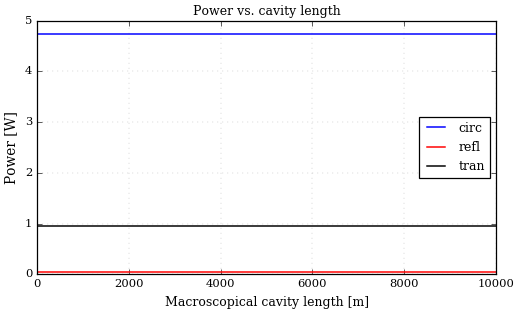

In [23]:
fig = out2.plot(ylabel = 'Power [W]', 
                xlabel = 'Macroscopical cavity length [m]',
                title = 'Power vs. cavity length')

The reflected, circulaiting and transmitted powers are unchanged when the macroscopical cavity length is changed. Since we have used phi=0 for both mirrors we are always on resonance.

## 3.2 Laser Frequency

The cavity resonance occurs when the cavity roundtrip length is an integer multiple of the laser wavelength. Thus we should be able to detune the cavity either by moving a mirror, as we did above, or by changing the laser frequency. Recreate the plot above, but this time tuning the laser frequency instead of the position of a mirror.

**Answer:**

In [24]:
kat3 = deepcopy(basekat)
code = """
## Detectors ##
pd refl nc1
pd circ nc2
pd tran nc4

## Simulation instructions ##
xaxis laser f lin -100k 20k 400  # Changing frequency of the laser.
yaxis abs 
"""
kat3.parseKatCode(code) # Parsing the FINESSE-Code
kat3.sL.L = 4000
out3 = kat3.run() # Running FINESSE, storing output as out3

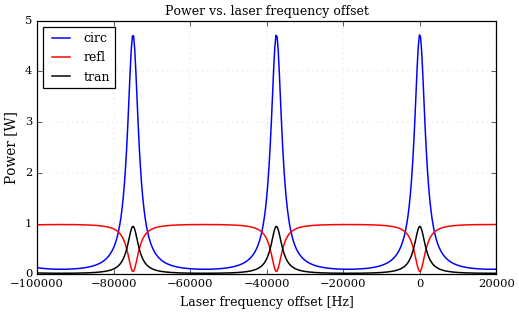

In [25]:
fig3 = out3.plot(ylabel = 'Power [W]',
                 xlabel = 'Laser frequency offset [Hz]',
                 title = 'Power vs. laser frequency offset')

## 3.3. Laser frequency and macroscopic cavity length

Set the laser frequency offset to 20 kHz, and repeat task 2.1. Why is the result different from task 2.1? *Hint: See 3.3.2 in the FINESSE manual.*

**Answer:**

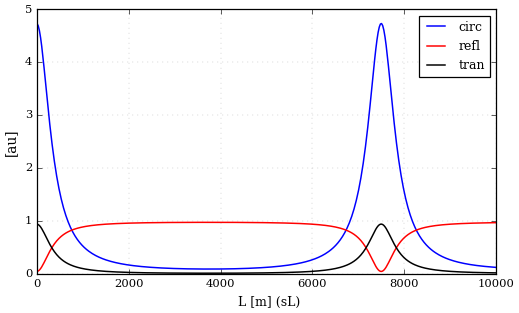

In [26]:
kat4 = deepcopy(kat2)
kat4.laser.f = 2.0e4
out4 = kat4.run()
fig4 = out4.plot()

In FINESSE the length of a space component is defined as an integer multiple of the wavelength set in the file *kat.ini*, which by default is $\lambda_0 = 1064$ nm. Hence, by changing the frequncy offset $\Delta f$ of the laser, the cavity length $L$ is no longer an integer multiple of the laser wavelength $\lambda$ and the total roundtrip phase is now given by

\begin{align}
\varphi_{rt} = -2i\left(\frac{2\pi \Delta f L}{c} + \phi \right).
\end{align}

Here, $\phi$ is the tuning and $c$ is the speed of light. Since the resonance condition for a single frequency component in a cavity is $\varphi_{rt} = 2n\pi$, where $n$ is an integer, the resonance clearly depends on the macroscopic cavity length when the laser is offset in frequency.

# 4. Summary

In this session we have:
* built a FINESSE model of a Fabry-Perot cavity
* investigated how the power depends on the mirror tuning (microscopical length)
* investigated how the power depends on the macroscopical cavity length
* investigated how the power depends on the macroscopical cavity length with an offset laser frequency. 

In the [next session](02_01_02_FSR_and_FWHM.ipynb) we will go through free spectral range and the line width of a peak. 